In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import warnings
warnings.filterwarnings('ignore')

## Pre modelling

### Load Data

In [2]:
# import libs
import pandas as pd

In [3]:
# Load the data
pd.set_option('max_colwidth', 1000)

train_df = pd.read_csv('./clean_data/train_data.csv')
test_df = pd.read_csv('./clean_data/test_data.csv')
val_df = pd.read_csv('./clean_data/val_data.csv')

In [4]:
train_df.head()

,cleaned_article,cleaned_summary
0,"TIGA kali somasi dilayangkan kepada Nuri Shaden . Namun reaksi yang diharapkan agar meminta maaf hasilnya nihil . Keluarga Janu Utomo melaporkan kasus kecelakaan di Jalan Sisingamaraja , Jakarta Selatan , 1 Juni silam itu ke Kepolisian Resor Metro Jaksel . Kita melaporkan atas dugaan tindak pidana , tutur Taufik Basari , kuasa hukum keluarga Janu , belum lama ini . Taufik menambahkan , pihaknya ingin Nuri mencabut pernyataan di depan pers , 2 Juni silam . Ia juga ingin Nuri meminta maaf di media atas kejadian itu . Dan juga menyampaikan belasungkawa . Taufik menilai , pernyataan Nuri memutarbalikkan fakta . Yang kita adukan soal pernyataanpernyataannya , ujar dia . Keluarga Janu melaporkan dengan dua tuduhan . Yakni sikap yang tidak menyenangkan dan pencemaran nama baik . Kala itu Nuri menuding mobil ambulans yang menabrak kendaraannya . Intinya mereka menabrak kita , ucap Nuri saat jumpa pers waktu itu . Pernyataan disampaikan bintang film Seventeen didampingi Noni T , pengacarany...",TIGA kali somasi dilayangkan kepada Nuri Shaden . Namun reaksi yang diharapkan agar meminta maaf hasilnya nihil . Keluarga Janu Utomo pun melaporkan Nuri ke Kepolisian Resor Metro Jakarta Selatan .
1,"Jakarta Earth Wind and Fire Experience Worldwide Tour 2006 Featuring Al Mckay All Star sukses memuaskan penikmat jazz yang memadati Grand Melia , Jakarta Selatan , Rabu malam . Pertunjukan ini adalah penampilan kedua dari rangkaian tur grup asal Chicago , Amerika Serikat itu di enam kota besar di Indonesia . Setelah Jakarta dan Bandung , mereka siap menggoyang Semarang , Yogyakarta , Surabaya , dan Medan . Tembang Serpentine Fire menjadi lagu pembuka Earth Wind and Fire . Dengan energik , trio vokal Tim Owens , Claude Woods , dan Devere Duckett berhasil memukau penonton . Diiringi Al Mckay All Star , mereka terus mendendangkan hits andalan , antara lain Pride dan Gotta Get You Into My Life . Meski Earth Wind and Fire terbilang grup lawas , tembang mereka tetap digemari . Buktinya 1 . 500 tiket yang disediakan untuk Jakarta ludes terjual .","Setelah di Bandung , Earth Wind and Fire giliran menghibur penikmat jazz di Jakarta , tadi malam . Lagulagu andalan grup asal Chicago itu mampu menyihir penonton sampai detik terakhir pertunjukan ."
2,"Jakarta Belasan unit mobil pemadam kebakaran dikerahkan untuk menjinakkan amukan si jago merah di sebuah rumah di kawasan Perumahan Patra Kuningan , Jakarta Selatan , Ahad sore . Petugas pemadam juga membuka paksa bagian tengah rumah bernomor sembilan itu untuk menyelamatkan isi hunian di Kompleks Perumahan Pertamina tersebut . Puluhan petugas pemadam disebar ke beberapa tempat untuk mencegah meluasnya kobaran api yang mulai menyala sekitar pukul 17 . 00 WIB . Beberapa warga sekitar mengatakan , bangunan yang selama ini berfungsi sebagai tempat istirahat petugas kebersihan itu , pada malam hari biasanya dijadikan tempat mangkal sejumlah pemuda . Api di lokasi kebakaran yang berjarak beberapa puluh meter dari rumah mantan Presiden B . J . Habibie itu berhasil dipadamkan dalam tempo dua jam . Hingga kini , belum diketahui jumlah kerugian . Sehari sebelumnya , si jago merah beraksi di Jalan Tubagus Angke , Jakarta Barat . Sebanyak 240 rumah hangus terbakar . Api mulai terlihat dari se...","Lokasi kebakaran di rumah bernomor sembilan di Perumahan Patra Kuningan , Jaksel , ini hanya berjarak puluhan meter dari kediaman mantan Presiden Habibie . Jumlah kerugian belum diketahui ."
3,"Empat tahun silam , Ballack terpaksa duduk di bangku cadangan ketika Jerman berjuang menahan gempuran Ronaldo dkk di babak final PD 2002 di JepangKorea . Akumulasi kartu kuning membuat playmaker Jerman itu harus menitikkan air mata menyaksikan Oliver Kahn dkk berjuang sendirian . Kini , di kandang sendiri , air mata kembali menggenang di pipi Ballack , setelah hanya dalam dua menit , performa gemilang dari anakanak Italia mengubur mimpi dan ambisi timnya melangkah ke babak pamungkas . Ballack pun seperti d

## Data Tokenizing

In [5]:
from transformers import AutoTokenizer

model_ckpt = "panggi/t5-base-indonesian-summarization-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [6]:
# convert the DataFrame into DatasetDict
import datasets
from datasets import Dataset

train_dataset = Dataset.from_dict(train_df.sample(frac = 0.03))
test_dataset = Dataset.from_dict(test_df.sample(frac = 0.03))
valid_dataset = Dataset.from_dict(val_df.sample(frac = 0.03))

dataset = datasets.DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
    "val": valid_dataset
})

dataset

DatasetDict({
    train: Dataset({
        features: ['cleaned_article', 'cleaned_summary'],
        num_rows: 5816
    })
    test: Dataset({
        features: ['cleaned_article', 'cleaned_summary'],
        num_rows: 329
    })
    val: Dataset({
        features: ['cleaned_article', 'cleaned_summary'],
        num_rows: 329
    })
})

#### Since the distribution is quite normal we used the mean for this 
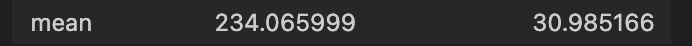

In [7]:
max_input_length = int(234)
max_target_length = int(30)

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["cleaned_article"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["cleaned_summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [8]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 329/329 [00:00<00:00, 5509.02 examples/s]


In [9]:
tokenized_datasets.data

{'train': InMemoryTable
 cleaned_article: string
 cleaned_summary: string
 input_ids: list<item: int32>
   child 0, item: int32
 attention_mask: list<item: int8>
   child 0, item: int8
 labels: list<item: int64>
   child 0, item: int64
 ----
 cleaned_article: [["Medan Melissa , bayi perempuan berusia enam bulan dianiaya ibu angkatnya hingga cacat permanen . Bayi malang itu menjalani perawatan intensif di Rumah Sakit Umum Pirngadi Medan , Sumatra Utara . Sekujur tubuhnya penuh akibat penganiayaan yang dilakukan JS , yang menjadi ibu asuhnya sejak dia dilahirkan . Wajahnya penuh luka serius . Selain pipi membengkak , kepala korban juga ditemukan bekas luka pukulan benda tumpul . Bahkan konstruksi hidung anak kandung pasangan Suher dan Suryani , warga Desa Bintang Meriah , Batang Kuis , Deli Serdang ini nyaris hilang akibat sundutan api rokok . Di kakinya ada bekas luka akibat jeratan tali . Menurut pihak RSU Pirngadi Medan , Melissa dirujuk ke rumah sakit Sabtu pekan lalu setelah tetangg

## Prep on evaluation Metrics

In [10]:
import evaluate

rouge_score = evaluate.load("rouge")

In [11]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge_score.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

## Modeling

### Load Model

In [12]:
from transformers import AutoModelForSeq2SeqLM
import torch

model_ckpt = "panggi/t5-base-indonesian-summarization-cased"

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

    # Move your model to mps just like any other device
    model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)
    model.to(mps_device)

### Generating Summaries using Pipline

In [13]:
from transformers import pipeline
# device 0 for metal backend as im using arm based device
summarizer = pipeline("summarization", model=model_ckpt, tokenizer=tokenizer, device=0)

### Fine-tuning T5 with Liputan6 data

In [14]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [15]:
from transformers import Seq2SeqTrainingArguments

batch_size = 32
num_train_epochs = 10
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_ckpt

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-L6",
    eval_strategy="steps",
    learning_rate=5.6e-4, #to be tuned 1
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    no_cuda=True,
    logging_steps=logging_steps,
    load_best_model_at_end = True,
    metric_for_best_model="eval_rouge1",  
    greater_is_better=True, 
    eval_steps=91,  # Evaluate every 91 steps (half of 182)
    save_steps=logging_steps
)

In [16]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

In [17]:
trainer.train()

  2%|▏         | 29/1820 [07:23<7:44:34, 15.56s/it]

### Test with few validation and test data

## Inference

In [ ]:
# Load the fine-tuned model and tokenizer
model_name = "pangi-t5-summ"  # Replace with your actual model name
model_dir = f"/Users/shabiras/Developer/Learn/AI/NLP/INDONESIA AI/Project_2/liputan6_data/panggi/t5-base-indonesian-summarization-cased-finetuned-L6/checkpoint-584"
tokenizerT5Result = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
# Create summarization pipeline
summarizer = pipeline("summarization", model=model, tokenizer=tokenizerT5Result)

OSError: Incorrect path_or_model_id: '/Users/shabiras/Developer/Learn/AI/NLP/INDONESIA AI/Project_2/liputan6_data/panggi/t5-base-indonesian-summarization-cased-finetuned-L6/checkpoint-584'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [ ]:
import time

# Inference function
def generate_summary(text):
    start_time = time.time()  # Start time measurement
    summary = summarizer(text, max_length=150, min_length=30, do_sample=False)[0]['summary_text']
    end_time = time.time()  # End time measurement
    inference_time = end_time - start_time
    return summary, inference_time

# Provided text
provided_text = """
Sekitar sepuluh anggota Reserse Kepolisian Resor Jakarta Pusat, Rabu (29/8) malam, menggeledah rumah Willy di Kompleks Pakuan Blok A Nomor 15 Jelambar, Jakarta Barat. Rumah tersebut digeledah karena polisi menduga Willy menyimpan senjata api organik yang biasa digunakan TNI untuk diperjualbelikan. Dugaan polisi bukan tak berdasar. Sebab, berdasarkan keterangan Albert, seorang pedagang baju militer di kawasan Pasar Baru, Jakpus, Willy adalah penjual senjata api. Albert diperiksa karena tertangkap saat polisi menggelar Operasi Sadar Jaya 2001, Selasa dini hari. Di dalam mobil Albert, polisi menemukan tiga pucuk senjata api, masing-masing dua senjata laras pendek dan satu laras panjang. Selain itu, polisi juga menyita 1.287 butir peluru. Albert mengaku membeli senjata dan peluru dari Willy, yang juga berprofesi sebagai pedagang pakaian militer di Pasar Baru. Ketika rumah Willy digeledah, Sri istri Willy menolak memberi keterangan. Ia mengaku tak mengerti atas penggeledahan tersebut. Selain Sri, Kepala Polres Jakpus Komisaris Besar Mathius Salempang juga enggan menjelaskan penggeledahan tersebut.
"""

# Generate summary for the provided text
summary, inference_time = generate_summary(provided_text)
print("Summary:", summary)
print("Inference Time:", inference_time, "seconds")

Summary: Sekitar sepuluh anggota Reserse Polisi Jakarta Pusat menggeledah rumah Willy di Kompleks Pakuan Blok A Nomor 15 Jelambar , Jakarta Barat. Polisi menemukan tiga pucuk senjata api dan menyita 1. 287 butir peluru.
Inference Time: 2.302338123321533 seconds
